# Using OSM Fetched Data to Calculate Distances to Centroid Using Analysis. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing necessary modules
import geopandas as gpd # used for handling geospatial data
import pandas as pd # used for creating and manipulating data in tabular format 
import folium # used to create interactive maps
import requests # used to send an API call, i.e., U.S Census Geocoder
import numpy as np
from geopy.geocoders import Nominatim

In [4]:
# import network analysis modules

In [ ]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from geopy.distance import geodesic

In [ ]:
# import plotting modules

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

## Step 1 - Get the Location Data using OSM

### Function to automate query in Open Streeet Map using Overpass Api. 
More information about how to geocode with OSM can be found here. https://wiki.openstreetmap.org/wiki/Overpass_API?form=MG0AV3#Introduction

#### Function to pass the query to Overpass API

#### For correct Query Input visit: https://wiki.openstreetmap.org/wiki/Map_features

##### Store names like "Target", "Walmart" wouldn't work in this case. We have to be more generic or specify Brand. 

In [13]:
def get_locations(categories, queries, cities, state, country, brand=None):
    """Fetch locations from OpenStreetMap using Overpass API."""
    overpass_url = "http://overpass-api.de/api/interpreter"
    all_locations = []

    # Construct the optional brand filter
    brand_filter = f'["brand"="{brand}"]' if brand else ''

    # Handle multiple categories, queries, and cities
    if not categories or not queries or not cities:
        print("No categories, queries, or cities provided.")
        return []

    for category in categories:
        for city in cities:
            for query in queries:
                overpass_query = f"""
                [out:json];
                area[name="{city}"]->.searchArea;
                (
                  node["{category}"="{query}"]{brand_filter}(area.searchArea);
                  way["{category}"="{query}"]{brand_filter}(area.searchArea);
                  relation["{category}"="{query}"]{brand_filter}(area.searchArea);
                );
                out center;
                """
                
                try:
                    response = requests.get(overpass_url, params={'data': overpass_query})
                    response.raise_for_status()
                    data = response.json()
                    all_locations.extend(data.get("elements", []))
                except requests.exceptions.RequestException as e:
                    print(f"Request error for {category}={query} in {city}: {e}")
                except requests.exceptions.JSONDecodeError:
                    print(f"Error decoding JSON response from API for {category}={query} in {city}.")

    return all_locations

In [15]:
def plot_locations(data, city, state, country):
    """Plot locations on a Folium map."""
    if not data:
        print("No locations found.")
        return None

    # Extract the first valid location for map centering
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            m = folium.Map(location=[lat, lon], zoom_start=12)
            break
    else:
        print("No valid coordinates found.")
        return None

    # Add markers
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            name = place.get('tags', {}).get('name', 'Unknown')
            folium.Marker([lat, lon], popup=f"{name} ({lat}, {lon})").add_to(m)

    return m

In [17]:
def display_locations(data):
    """Display location names with coordinates in a DataFrame."""
    locations = []
    for place in data:
        lat = place.get('lat') or (place.get('center', {}).get('lat'))
        lon = place.get('lon') or (place.get('center', {}).get('lon'))
        if lat and lon:
            name = place.get('tags', {}).get('name', 'Unknown')
            locations.append([name, lat, lon])
    
    df = pd.DataFrame(locations, columns=['Name', 'Latitude', 'Longitude'])
    return df

#### Fetching Supermarket and Department Locations in West Lafayette

In [23]:
# Example Query Parameters
category = ["shop"]  # General category
queries = ["supermarket", "department_store"]
cities = ["West Lafayette"]
state = "Indiana"
country = "USA"
brand = None  # Change to "Walmart" or "Target" if needed or None 

# Fetch Data
data = get_locations(category, queries, cities, state, country, brand)

# Plot Data on Map
map_result = plot_locations(data, cities[0] if cities else None, state, country)

# Display DataFrame of Locations
df_locations = display_locations(data)

# Display the map and data
if map_result:
    display(map_result)

In [25]:
df_locations

,Name,Latitude,Longitude
0,Walmart Supercenter,40.457047,-86.932916
1,PayLess,40.455324,-86.917627
2,ALDI,40.453912,-86.908779
3,Better World Market,40.422321,-86.898412
4,Meijer,40.469946,-86.956774
5,Asia Global Market,40.452241,-86.924048
6,Fresh Thyme,40.451923,-86.913942
7,Target,40.424070,-86.908142


## Step 2 - Pass the Fetched Locations to Calculated Distances to Centroid Using Network Analysis

In [29]:
graph = ox.graph_from_place("West Lafayette, Indiana", network_type="drive")

In [ ]:
# save the graph

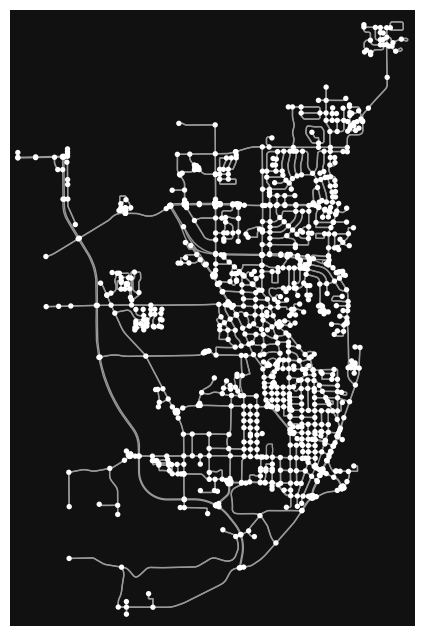

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
ox.plot_graph(graph)

### Add Travel Times / Speeds 

In [33]:
graph = ox.add_edge_speeds(graph)

In [35]:
graph = ox.add_edge_travel_times(graph)

In [57]:
# Extract node positions and calculate the centroid
node_positions = np.array([[data['x'], data['y']] for _, data in graph.nodes(data=True)])
centroid = node_positions.mean(axis=0)
centroid_node = ox.nearest_nodes(graph, X=centroid[0], Y=centroid[1])

In [59]:
# Define a colormap to assign colors dynamically
num_locations = len(df_locations)
colormap = cm.get_cmap('tab20', num_locations)
colors = [colormap(i) for i in range(num_locations)]

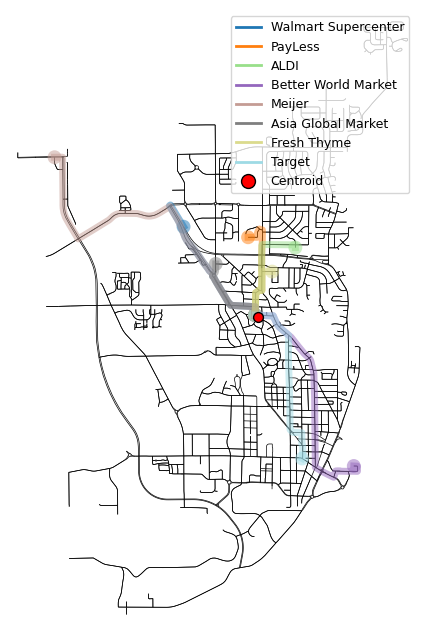

In [114]:
# Create lists to store travel distances and times
travel_distances = []
travel_times = []

# Plot the graph
fig, ax = ox.plot_graph(graph, bgcolor="white", node_size=0, edge_color="black", edge_linewidth=0.5, show=False, close=False)

# Loop through each location and plot the shortest path to the centroid
for idx, row in df_locations.iterrows():
    
    # Find the nearest node to the location coordinates
    location_node = ox.nearest_nodes(graph, X=row['Longitude'], Y=row['Latitude'])
    
    # Calculate the shortest path route
    route = nx.shortest_path(graph, source=location_node, target=centroid_node, weight='travel_time')
    # Calculate the travel distance and time
    travel_time = nx.shortest_path_length(graph, source=location_node, target=centroid_node, weight='travel_time')
    travel_distance = nx.shortest_path_length(graph, source=location_node, target=centroid_node, weight='length')

    # Append the results to the lists
    travel_distances.append(travel_distance)
    travel_times.append(travel_time)
    
    # Plot the route with different colors
    ox.plot_graph_route(graph, route, route_color=colors[idx], route_linewidth=5, ax=ax, show=False, close=False)

# Highlight the centroid with a red dot
ax.scatter(centroid[0], centroid[1], c='red', edgecolor="k", s=50, zorder=10)

# Add a legend
labels = df_locations['Name'].tolist() + ['Centroid']
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(num_locations)] + [plt.Line2D([0], [0], marker='o', color="white", markerfacecolor='red', markersize=10, markeredgecolor="black")]
ax.legend(handles, labels, loc='best', fontsize=9)

### Travel Distances and Times to Centroid

In [106]:
# Create a DataFrame to display the travel distances and times
results_df = pd.DataFrame({
    'Name': df_locations['Name'],
    'Travel Distance (m)': travel_distances,
    'Travel Time (seconds)': travel_times
})

# Display the results DataFrame
display(results_df)

,Name,Travel Distance (m),Travel Time (seconds)
0,Walmart Supercenter,2818.729781,175.538086
1,PayLess,1785.555572,156.024393
2,ALDI,1787.705439,156.891638
3,Better World Market,3753.796783,324.463653
4,Meijer,5258.265358,358.758436
5,Asia Global Market,1267.464427,95.734743
6,Fresh Thyme,942.296366,89.094424
7,Target,2824.731754,232.985691
